In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.optim.lr_scheduler import (
    OneCycleLR,
    CosineAnnealingLR,
    ReduceLROnPlateau
)
from pandas import DataFrame
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
DATA_PATH = '/kaggle/input/dog-vs-cat-vs-bird/dataset/'
IMAGES_PATH = DATA_PATH + 'train/'
LABEL_PATH = DATA_PATH + 'train.csv'
OUTPUT_PATH = '/kaggle/working/'
# DATA_PATH = './dog-vs-cat-vs-bird/dataset/'
# IMAGES_PATH = DATA_PATH + 'train/'
# LABEL_PATH = DATA_PATH + 'train.csv'
# OUTPUT_PATH = './models/'

RANDOM_STATE = 42
TRAIN_SIZE = 0.8
EPOCHS = 200
MODEL_NUM_OFFSET = 0
BATCH_SIZE = 64
WEIGHTED_CONV = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(RANDOM_STATE)

# Dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir_path, transform):
        self.df = dataframe
        self.img_dir_path = img_dir_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['filename']        
        img_path = os.path.join(self.img_dir_path, img_name)
        
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = row['label']
        
        return img, label

In [4]:
class_to_index = {'cat': 0, 'dog': 1, 'bird': 2, }

df = pd.read_csv(LABEL_PATH)
df['label'] = df['label'].apply(lambda x: class_to_index[x])
train_df, val_df = train_test_split(
    df,
    test_size=1 - TRAIN_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomResizedCrop(32),         
    # transforms.RandomHorizontalFlip(p=0.5), 
    # transforms.RandomRotation(degrees=15),
    # transforms.ColorJitter(
    #     brightness=0.2,
    #     contrast=0.2,
    #     saturation=0.2,
    #     hue=0.1
    # ),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# apply this on gpu instead
preprocess2 = transforms.Compose([
    # transforms.RandomResizedCrop(32, (0.08, 1.0)),         
    # transforms.RandomHorizontalFlip(p=0.5), 
    # transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.18,
        contrast=0.18,
        saturation=0.18,
        hue=0.1
    ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=6),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_preprocess2 = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ds = CustomDataset(train_df, IMAGES_PATH, preprocess)
val_ds = CustomDataset(val_df, IMAGES_PATH, val_preprocess)

train_dl = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    prefetch_factor=2,
)

val_dl = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    prefetch_factor=2,
)

# Model

Conv2d with bias=False and applied after BatchNorm2d

In [5]:
class BatchedConv2d(nn.Module):
    def __init__(
            self, 
            in_channels, 
            out_channels, 
            stride=1, 
            kernel_size=3, 
            padding=0,
            groups=1
        ): 
        super(BatchedConv2d, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            kernel_size=kernel_size,
            padding=padding,
            groups=groups,
            bias=False,
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        return out

Apply different weighted sum on in_channels for each kernels (num kernels = out_channels).

Avoiding typical pytorch conv2d which use sub kernels (num kernels = in_channels * out_channels)

In [6]:
class WeightedSumConv2d(nn.Module):
    def __init__(
            self, 
            in_channels, 
            out_channels, 
            stride=1, 
            kernel_size=3, 
            padding=0
        ):
        super(WeightedSumConv2d, self).__init__()
        # self.weighted_sum = nn.Linear(in_channels, out_channels, bias=False)
        self.weighted_sum = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=1, 
            bias=False
        )
        self.batch_conv = BatchedConv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            stride=stride,
            kernel_size=kernel_size,
            padding=padding,
            groups=out_channels
        )

    def forward(self, x):
        # x = self.weighted_sum(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x = self.weighted_sum(x)
        x = self.batch_conv(x)
        return x

CNN model with residual

In [7]:
Conv = BatchedConv2d
if WEIGHTED_CONV:
    Conv = WeightedSumConv2d

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = Conv(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = Conv(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = Conv(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        identity = self.downsample(x)
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += identity
        return F.relu(out)
        
class Model(nn.Module):
    def __init__(self, num_classes=3):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.layer1 = nn.Sequential(
            BasicBlock(16, 16, stride=1),
            BasicBlock(16, 16, stride=1),
            BasicBlock(16, 32, stride=2),
            BasicBlock(32, 32, stride=1),
            BasicBlock(32, 64, stride=2),
            BasicBlock(64, 64, stride=1),
        )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [8]:
# img = torch.rand(4, 3, 32, 32)
# model = Model()
# model(img).shape

# Training & Validation

In [9]:
def train(model, dataloader, loss_func, optimizer, scheduler=None, device='cpu'):
    model.train()
    total_loss = 0.0
    total_batches = len(dataloader)
    for i, (data, target) in enumerate(dataloader):
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        # pytorch >= 1.7
        optimizer.zero_grad(set_to_none=True)

        data = preprocess2(data)

        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        # use this for OneCycleLR
        # if isinstance(scheduler, OneCycleLR):
        scheduler.step()
            
        total_loss += loss.detach()

        if i % 10 == 0:
            print(f"Batch: {i}/{total_batches}", end='\r')

    # if isinstance(scheduler, CosineAnnealingLR):
    # scheduler.step()
    torch.cuda.synchronize() 
    return (total_loss / total_batches).item()

@torch.no_grad()
def val(model, dataloader, loss_func, device='cpu'):
    # print()
    model.eval()
    total_loss = 0.0
    for i, (data, target) in enumerate(dataloader):
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        data = val_preprocess2(data)
        
        pred = model.forward(data)
        total_loss += loss_func(pred, target).detach()
        
    torch.cuda.synchronize() 
    return (total_loss / len(dataloader)).item()

Model initialization

In [10]:
model = Model()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(DEVICE)

# try:
#     model = torch.compile(model, mode="reduce-overhead")
# except Exception as e:
#     print(f"Compilation failed: {e}")
#     print("Falling back to eager mode")

loss_func = F.cross_entropy
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dl),
    pct_start=0.3,
    div_factor=25,
    final_div_factor=1000,
)

# Option 2: CosineAnnealingLR (For longer traning run)
# scheduler = CosineAnnealingLR(
#     optimizer,
#     T_max=EPOCHS,
#     eta_min=1e-6
# )

Number of parameters

In [11]:
sum(p.numel() for p in model.parameters() if p.requires_grad)
# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# params = sum([np.prod(p.size()) for p in model_parameters])
# params

27363

Training and Validation Loop

In [12]:
all_train_losses = []
all_val_losses = []

for i in range(EPOCHS):
    train_loss = train(model, train_dl, loss_func, optimizer, scheduler, DEVICE)
    val_loss = val(model, val_dl, loss_func, DEVICE)

    diff = train_loss-val_loss

    print(f'Epoch {i} \t Train: {train_loss:.5f}  Val: {val_loss:.5f}  Diff: {diff:.5f} \t lr: {optimizer.param_groups[0]["lr"]:.8f}')

    # torch.save(model.state_dict(), os.path.join(OUTPUT_PATH, f'model_{i + MODEL_NUM_OFFSET}.pt'))

    all_train_losses.append(train_loss)
    all_val_losses.append(val_loss)

    # if diff <= -0.2: break

Epoch 0 	 Train: 1.10804  Val: 1.08885  Diff: 0.01920 	 lr: 0.00004066
Epoch 1 	 Train: 1.08519  Val: 1.07310  Diff: 0.01208 	 lr: 0.00004263
Epoch 2 	 Train: 1.06851  Val: 1.07963  Diff: -0.01113 	 lr: 0.00004591
Epoch 3 	 Train: 1.05378  Val: 1.07046  Diff: -0.01668 	 lr: 0.00005049
Epoch 4 	 Train: 1.04505  Val: 1.07192  Diff: -0.02686 	 lr: 0.00005636
Epoch 5 	 Train: 1.02753  Val: 1.06102  Diff: -0.03349 	 lr: 0.00006350
Epoch 6 	 Train: 1.00730  Val: 1.02385  Diff: -0.01654 	 lr: 0.00007189
Epoch 7 	 Train: 0.99577  Val: 1.01753  Diff: -0.02176 	 lr: 0.00008151
Epoch 8 	 Train: 0.98690  Val: 0.99362  Diff: -0.00673 	 lr: 0.00009233
Epoch 9 	 Train: 0.97140  Val: 0.99104  Diff: -0.01964 	 lr: 0.00010432
Epoch 10 	 Train: 0.96375  Val: 0.94345  Diff: 0.02030 	 lr: 0.00011745
Epoch 11 	 Train: 0.96008  Val: 0.94984  Diff: 0.01024 	 lr: 0.00013169
Epoch 12 	 Train: 0.93493  Val: 0.95082  Diff: -0.01590 	 lr: 0.00014699
Epoch 13 	 Train: 0.92947  Val: 0.94529  Diff: -0.01582 	 lr: 0.0

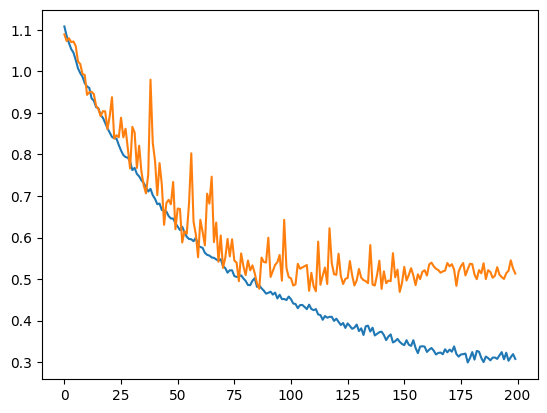

In [13]:
plt.plot(all_train_losses)
plt.plot(all_val_losses)
plt.show()

In [14]:
pd.DataFrame({
    'train': all_train_losses,
    'test': all_val_losses,
}).to_csv('/kaggle/working/losses1.csv')

In [15]:
np.argmin(all_val_losses)

148

In [16]:
all_val_losses[105]

0.527919352054596